# Capstone Project: English Premier League Predictions

# Part 4B - Preprocessing, Modeling & Evaluation for Away Total Goals

In this notebook, we will be training the model for our target variable, Away Total Goals.  Similarly to Result, we will be using the dataset which we have combined in the notebook Part 2.

The models used to train will be as followed in the contents. We will grid search for the best parameters for each models then use it with the models.

### Contents:

- [Preparing Dataset for Prediction of Away Total Goals](#Preparing-Dataset-for-Prediction-of-Away-Total-Goals)
    - [Away Total Goals Classes](#Away-Total-Goals-Classes)
    - [Removing Features that will be Irrelevant](#Removing-Features-that-will-be-Irrelevant)
    
- [Building the Model](#Building-the-Modeling)
    - [Train Test Split for Away Total Goals](#Train-Test-Split-for-Away-Total-Goals)
    - [Logistic Regression](#Logistic-Regression)
    - [Random Forest Classification](#Random-Forest-Classification)
    - [ExtraTrees Classifier](#ExtraTrees-Classifier)
    - [AdaBoost Classifier](#AdaBoost-Classifier)
    - [Gradient Boost Classifier](#Gradient-Boost-Classifier)
    - [Support Vector Classifier](#Support-Vector-Classifier)
    - [Model Evaluation & Selection](#Model-Evaluation-&-Selection)

In [1]:
#Importing of modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import pickle

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree, export_graphviz
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix,precision_score,confusion_matrix,accuracy_score,recall_score,f1_score,precision_recall_fscore_support

from imblearn.over_sampling import SMOTE

import warnings
import graphviz
warnings.filterwarnings("ignore")

pd.set_option('max_columns',None)

## Preparing Dataset for Prediction of Away Total Goals

Firstly, we will prepare the final dataset for prediction of total goals for Away. We will look through null values and remove features such as current matches stats as they will only happen after a match happened.

In [2]:
#Reading in of database
train = pd.read_csv('data/clean/combined_final.csv')

In [3]:
#We still have 280 features, we will look into remove some
train.shape

(1324, 264)

In [4]:
#Looking for null values
train.isnull().sum()[train.isnull().sum()>0] 

h_last_5_avrg_gls         12
h_last_5_avrg_ast         12
h_last_5_avrg_pk          12
h_last_5_avrg_pkatt       12
h_last_5_avrg_sh          12
                          ..
a_last_3_avrg_pkcon       15
a_last_3_avrg_og          15
a_last_3_avrg_recov       15
a_last_3_avrg_aer_won     15
a_last_3_avrg_aer_lost    15
Length: 144, dtype: int64

In [5]:
train.head(5)

,date,match,home,stadium,attendance,h_gls,h_ast,h_pk,h_pkatt,h_sh,h_sot,h_yellow,h_red,h_touches,h_press,h_tkl,h_int,h_blk,h_xg,h_npxg,h_xa,h_sca,h_gca,h_cmp,h_pass_att,h_pass_prog,h_carries,h_carries_prog,h_dri_succ,h_dri_att,h_yellow2,h_fls,h_fld,h_off,h_crs,h_tklw,h_pkwon,h_pkcon,h_og,h_recov,h_aer_won,h_aer_lost,h_last_5_avrg_gls,h_last_5_avrg_ast,h_last_5_avrg_pk,h_last_5_avrg_pkatt,h_last_5_avrg_sh,h_last_5_avrg_sot,h_last_5_avrg_yellow,h_last_5_avrg_red,h_last_5_touches,h_last_5_avrg_press,h_last_5_avrg_tkl,h_last_5_avrg_int,h_last_5_avrg_blk,h_last_5_avrg_xg,h_last_5_avrg_xa,h_last_5_avrg_sca,h_last_5_avrg_gca,h_last_5_avrg_cmp,h_last_5_avrg_pass_att,h_last_5_avrg_pass_prog,h_last_5_avrg_carries,h_last_5_avrg_carries_prog,h_last_5_avrg_dri_succ,h_last_5_avrg_dri_att,h_last_5_avrg_yellow2,h_last_5_avrg_fls,h_last_5_avrg_fld,h_last_5_avrg_off,h_last_5_avrg_crs,h_last_5_avrg_tklw,h_last_5_avrg_pkwon,h_last_5_avrg_pkcon,h_last_5_avrg_og,h_last_5_avrg_recov,h_last_5_avrg_aer_won,h_last_5_avrg_aer_lost,h_last_3_avrg_gls,h_last_3_avrg_ast,h_last_3_avrg_pk,h_last_3_avrg_pkatt,h_last_3_avrg_sh,h_last_3_avrg_sot,h_last_3_avrg_yellow,h_last_3_avrg_red,h_last_3_touches,h_last_3_avrg_press,h_last_3_avrg_tkl,h_last_3_avrg_int,h_last_3_avrg_blk,h_last_3_avrg_xg,h_last_3_avrg_xa,h_last_3_avrg_sca,h_last_3_avrg_gca,h_last_3_avrg_cmp,h_last_3_avrg_pass_att,h_last_3_avrg_pass_prog,h_last_3_avrg_carries,h_last_3_avrg_carries_prog,h_last_3_avrg_dri_succ,h_last_3_avrg_dri_att,h_last_3_avrg_yellow2,h_last_3_avrg_fls,h_last_3_avrg_fld,h_last_3_avrg_off,h_last_3_avrg_crs,h_last_3_avrg_tklw,h_last_3_avrg_pkwon,h_last_3_avrg_pkcon,h_last_3_avrg_og,h_last_3_avrg_recov,h_last_3_avrg_aer_won,h_last_3_avrg_aer_lost,away,a_gls,a_ast,a_pk,a_pkatt,a_sh,a_sot,a_yellow,a_red,a_touches,a_press,a_tkl,a_int,a_blk,a_xg,a_npxg,a_xa,a_sca,a_gca,a_cmp,a_pass_att,a_pass_prog,a_carries,a_carries_prog,a_dri_succ,a_dri_att,a_yellow2,a_fls,a_fld,a_off,a_crs,a_tklw,a_pwon,a_pkcon,a_og,a_recov,a_aer_won,a_aer_lost,a_last_5_avrg_gls,a_last_5_avrg_ast,a_last_5_avrg_pk,a_last_5_avrg_pkatt,a_last_5_avrg_sh,a_last_5_avrg_sot,a_last_5_avrg_yellow,a_last_5_avrg_red,a_last_5_touches,a_last_5_avrg_press,a_last_5_avrg_tkl,a_last_5_avrg_int,a_last_5_avrg_blk,a_last_5_avrg_xg,a_last_5_avrg_xa,a_last_5_avrg_sca,a_last_5_avrg_gca,a_last_5_avrg_cmp,a_last_5_avrg_pass_att,a_last_5_avrg_pass_prog,a_last_5_avrg_carries,a_last_5_avrg_carries_prog,a_last_5_avrg_dri_succ,a_last_5_avrg_dri_att,a_last_5_avrg_yellow2,a_last_5_avrg_fls,a_last_5_avrg_fld,a_last_5_avrg_off,a_last_5_avrg_crs,a_last_5_avrg_tklw,a_last_5_avrg_pkwon,a_last_5_avrg_pkcon,a_last_5_avrg_og,a_last_5_avrg_recov,a_last_5_avrg_aer_won,a_last_5_avrg_aer_lost,a_last_3_avrg_gls,a_last_3_avrg_ast,a_last_3_avrg_pk,a_last_3_avrg_pkatt,a_last_3_avrg_sh,a_last_3_avrg_sot,a_last_3_avrg_yellow,a_last_3_avrg_red,a_last_3_touches,a_last_3_avrg_press,a_last_3_avrg_tkl,a_last_3_avrg_int,a_last_3_avrg_blk,a_last_3_avrg_xg,a_last_3_avrg_xa,a_last_3_avrg_sca,a_last_3_avrg_gca,a_last_3_avrg_cmp,a_last_3_avrg_pass_att,a_last_3_avrg_pass_prog,a_last_3_avrg_carries,a_last_3_avrg_carries_prog,a_last_3_avrg_dri_succ,a_last_3_avrg_dri_att,a_last_3_avrg_yellow2,a_last_3_avrg_fls,a_last_3_avrg_fld,a_last_3_avrg_off,a_last_3_avrg_crs,a_last_3_avrg_tklw,a_last_3_avrg_pkwon,a_last_3_avrg_pkcon,a_last_3_avrg_og,a_last_3_avrg_recov,a_last_3_avrg_aer_won,a_last_3_avrg_aer_lost,result,h_last5match,h_accumulatpts,a_last5match,a_accumulatpts,h_total_goals,a_total_goals,total_goals,h_total_value_eur,h_total_wage_eur,h_average_age,h_average_height_cm,h_average_weight_kg,h_average_overall,h_average_potential,h_int_rep,h_skill_moves,h_age_std,h_height_cm_std,h_weight_kg_std,h_overall_std,h_potential_std,h_int_repn_std,h_skills_moves_std,a_total_value_eur,a_total_wage_eur,a_average_age,a_average_height_cm,a_average_weight_kg,a_average_overall,a_average_potential,a_average_int_rep,a_average_skill_moves,a_age_std,a_height_cm_std,a_weight_kg_std,a_overall_std,a_pot

The null values are from the last 5 or last 3 games stats. They are all at the first game each team played. This is due to no previous record for the last 5 games or last 3 games. We will be removing those matches in this case.

In [6]:
#Remove rows with null values
train = train.dropna(axis='rows')

In [7]:
#Checking for any remaining null values
train.isnull().sum()[train.isnull().sum()>0] 

Series([], dtype: int64)

In [8]:
#After removing, we are left with 1307 rows.
train.shape

(1307, 264)

### Away Total Goals Classes

As we are predicting the number of away total goals, we will be looking into the number of classes. The range for away goals is 0 - 9. The data is very imbalanced, so we will remove some outliers.

In [9]:
#Looking at a_total_goals
train['a_total_goals'].value_counts()

1    439
0    428
2    257
3    124
4     37
5     16
6      4
7      1
9      1
Name: a_total_goals, dtype: int64

In [10]:
train.loc[train['a_total_goals'] >= 7]

,date,match,home,stadium,attendance,h_gls,h_ast,h_pk,h_pkatt,h_sh,h_sot,h_yellow,h_red,h_touches,h_press,h_tkl,h_int,h_blk,h_xg,h_npxg,h_xa,h_sca,h_gca,h_cmp,h_pass_att,h_pass_prog,h_carries,h_carries_prog,h_dri_succ,h_dri_att,h_yellow2,h_fls,h_fld,h_off,h_crs,h_tklw,h_pkwon,h_pkcon,h_og,h_recov,h_aer_won,h_aer_lost,h_last_5_avrg_gls,h_last_5_avrg_ast,h_last_5_avrg_pk,h_last_5_avrg_pkatt,h_last_5_avrg_sh,h_last_5_avrg_sot,h_last_5_avrg_yellow,h_last_5_avrg_red,h_last_5_touches,h_last_5_avrg_press,h_last_5_avrg_tkl,h_last_5_avrg_int,h_last_5_avrg_blk,h_last_5_avrg_xg,h_last_5_avrg_xa,h_last_5_avrg_sca,h_last_5_avrg_gca,h_last_5_avrg_cmp,h_last_5_avrg_pass_att,h_last_5_avrg_pass_prog,h_last_5_avrg_carries,h_last_5_avrg_carries_prog,h_last_5_avrg_dri_succ,h_last_5_avrg_dri_att,h_last_5_avrg_yellow2,h_last_5_avrg_fls,h_last_5_avrg_fld,h_last_5_avrg_off,h_last_5_avrg_crs,h_last_5_avrg_tklw,h_last_5_avrg_pkwon,h_last_5_avrg_pkcon,h_last_5_avrg_og,h_last_5_avrg_recov,h_last_5_avrg_aer_won,h_last_5_avrg_aer_lost,h_last_3_avrg_gls,h_last_3_avrg_ast,h_last_3_avrg_pk,h_last_3_avrg_pkatt,h_last_3_avrg_sh,h_last_3_avrg_sot,h_last_3_avrg_yellow,h_last_3_avrg_red,h_last_3_touches,h_last_3_avrg_press,h_last_3_avrg_tkl,h_last_3_avrg_int,h_last_3_avrg_blk,h_last_3_avrg_xg,h_last_3_avrg_xa,h_last_3_avrg_sca,h_last_3_avrg_gca,h_last_3_avrg_cmp,h_last_3_avrg_pass_att,h_last_3_avrg_pass_prog,h_last_3_avrg_carries,h_last_3_avrg_carries_prog,h_last_3_avrg_dri_succ,h_last_3_avrg_dri_att,h_last_3_avrg_yellow2,h_last_3_avrg_fls,h_last_3_avrg_fld,h_last_3_avrg_off,h_last_3_avrg_crs,h_last_3_avrg_tklw,h_last_3_avrg_pkwon,h_last_3_avrg_pkcon,h_last_3_avrg_og,h_last_3_avrg_recov,h_last_3_avrg_aer_won,h_last_3_avrg_aer_lost,away,a_gls,a_ast,a_pk,a_pkatt,a_sh,a_sot,a_yellow,a_red,a_touches,a_press,a_tkl,a_int,a_blk,a_xg,a_npxg,a_xa,a_sca,a_gca,a_cmp,a_pass_att,a_pass_prog,a_carries,a_carries_prog,a_dri_succ,a_dri_att,a_yellow2,a_fls,a_fld,a_off,a_crs,a_tklw,a_pwon,a_pkcon,a_og,a_recov,a_aer_won,a_aer_lost,a_last_5_avrg_gls,a_last_5_avrg_ast,a_last_5_avrg_pk,a_last_5_avrg_pkatt,a_last_5_avrg_sh,a_last_5_avrg_sot,a_last_5_avrg_yellow,a_last_5_avrg_red,a_last_5_touches,a_last_5_avrg_press,a_last_5_avrg_tkl,a_last_5_avrg_int,a_last_5_avrg_blk,a_last_5_avrg_xg,a_last_5_avrg_xa,a_last_5_avrg_sca,a_last_5_avrg_gca,a_last_5_avrg_cmp,a_last_5_avrg_pass_att,a_last_5_avrg_pass_prog,a_last_5_avrg_carries,a_last_5_avrg_carries_prog,a_last_5_avrg_dri_succ,a_last_5_avrg_dri_att,a_last_5_avrg_yellow2,a_last_5_avrg_fls,a_last_5_avrg_fld,a_last_5_avrg_off,a_last_5_avrg_crs,a_last_5_avrg_tklw,a_last_5_avrg_pkwon,a_last_5_avrg_pkcon,a_last_5_avrg_og,a_last_5_avrg_recov,a_last_5_avrg_aer_won,a_last_5_avrg_aer_lost,a_last_3_avrg_gls,a_last_3_avrg_ast,a_last_3_avrg_pk,a_last_3_avrg_pkatt,a_last_3_avrg_sh,a_last_3_avrg_sot,a_last_3_avrg_yellow,a_last_3_avrg_red,a_last_3_touches,a_last_3_avrg_press,a_last_3_avrg_tkl,a_last_3_avrg_int,a_last_3_avrg_blk,a_last_3_avrg_xg,a_last_3_avrg_xa,a_last_3_avrg_sca,a_last_3_avrg_gca,a_last_3_avrg_cmp,a_last_3_avrg_pass_att,a_last_3_avrg_pass_prog,a_last_3_avrg_carries,a_last_3_avrg_carries_prog,a_last_3_avrg_dri_succ,a_last_3_avrg_dri_att,a_last_3_avrg_yellow2,a_last_3_avrg_fls,a_last_3_avrg_fld,a_last_3_avrg_off,a_last_3_avrg_crs,a_last_3_avrg_tklw,a_last_3_avrg_pkwon,a_last_3_avrg_pkcon,a_last_3_avrg_og,a_last_3_avrg_recov,a_last_3_avrg_aer_won,a_last_3_avrg_aer_lost,result,h_last5match,h_accumulatpts,a_last5match,a_accumulatpts,h_total_goals,a_total_goals,total_goals,h_total_value_eur,h_total_wage_eur,h_average_age,h_average_height_cm,h_average_weight_kg,h_average_overall,h_average_potential,h_int_rep,h_skill_moves,h_age_std,h_height_cm_std,h_weight_kg_std,h_overall_std,h_potential_std,h_int_repn_std,h_skills_moves_std,a_total_value_eur,a_total_wage_eur,a_average_age,a_average_height_cm,a_average_weight_kg,a_average_overall,a_average_potential,a_average_int_rep,a_average_skill_moves,a_age_std,a_height_cm_std,a_weight_kg_std,a_overall_std,a_pot

We will be dropping matches with away total goals more than 7. We will do the same for matches with more than 7 home total goals. 

In [11]:
#Removing rows that are outliers
train.drop(labels=[70,850,813,1176,1268],axis=0,inplace=True)

In [12]:
train['a_total_goals'].value_counts()

1    439
0    427
2    255
3    124
4     37
5     16
6      4
Name: a_total_goals, dtype: int64

### Removing features that will be Irrelevant

We will ready the features that will be used to train the model for away total goals. Similarly, we will remove curret match stats as we will not know the stats till the match have been played. After that, we will remove features that are not so correlated.


In [13]:
#Dropping of irrelevant features
train_1 = train.drop(columns = ['h_total_goals','result','attendance','h_gls','h_ast','h_pk','h_pkatt','h_sh','h_sot','h_yellow','h_red',
                              'h_touches','h_press','h_tkl','h_int','h_blk','h_xg','h_xa','h_sca','h_gca','h_cmp','h_pass_att',
                              'h_pass_prog','h_carries','h_carries_prog','h_dri_succ','h_dri_att','h_yellow2','h_fls','h_fld','h_off',
                              'h_crs','h_tklw','h_pkwon','h_pkcon','h_og','h_recov','h_aer_won','h_aer_lost','h_last5match','a_last5match','a_gls',
                              'a_ast','a_pk','a_pkatt','a_sh','a_sot','a_yellow', 'a_red', 'a_touches', 'a_press', 'a_tkl', 'a_int', 'a_blk',
                             'a_xg','a_xa','a_sca','a_gca','a_cmp','a_pass_att','a_pass_prog','a_carries', 'a_carries_prog', 'a_dri_succ',
                              'a_dri_att','a_yellow2','a_fls','a_fld','a_off','a_crs','a_tklw','a_pwon','a_pkcon','a_og','a_recov','a_aer_won','a_aer_lost',
                                'total_goals','h_npxg','a_npxg'])

Text(0.5, 1.0, 'Away Total Goals VS Features')

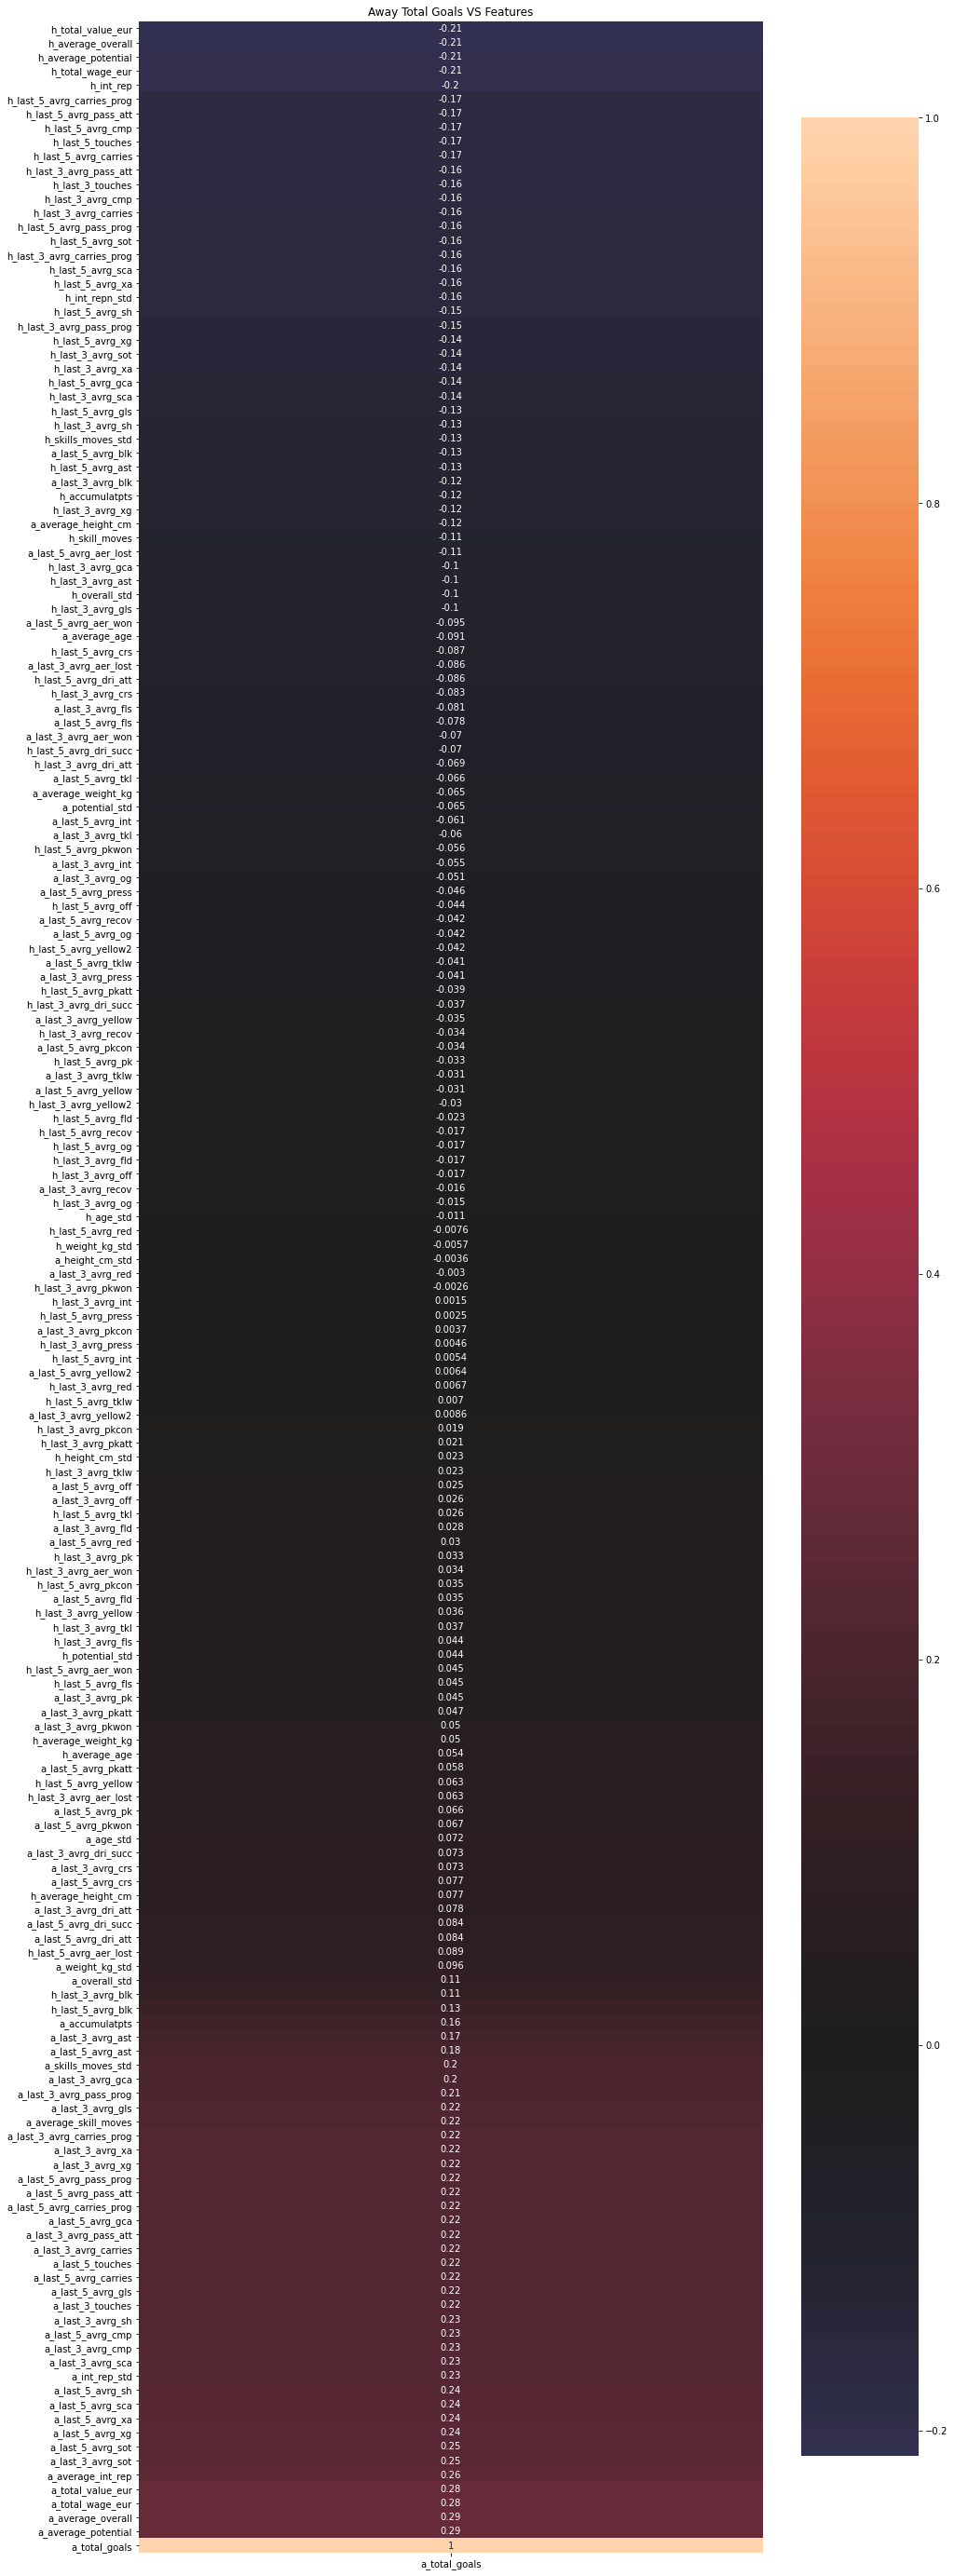

In [14]:
plt.figure(figsize=(15,50))
sns.heatmap(train_1.corr()[['a_total_goals']].sort_values('a_total_goals'), annot=True,center =0)
plt.title('Away Total Goals VS Features')

Looking at the heatmap, most of the negatively correlated stats are home team stats. Top fews are the team statistics.
Positively correlated features are mostly away stats. Simiarly, top few are the team statistics

We will remove features which are correlated between 0.22 to -0.15. This is due to that there are lesser features that are negatively correlated and we will try to make the features balanced.

In [15]:
#Let's remove features which are correlated between 0.22 and -0.15
train_corrs = train_1.corrwith(train['a_total_goals'])
train_corrs_index = train_corrs[(train_corrs < 0.22) & (train_corrs > -0.15)].index
list(train_corrs_index)

['h_last_5_avrg_gls',
 'h_last_5_avrg_ast',
 'h_last_5_avrg_pk',
 'h_last_5_avrg_pkatt',
 'h_last_5_avrg_yellow',
 'h_last_5_avrg_red',
 'h_last_5_avrg_press',
 'h_last_5_avrg_tkl',
 'h_last_5_avrg_int',
 'h_last_5_avrg_blk',
 'h_last_5_avrg_xg',
 'h_last_5_avrg_gca',
 'h_last_5_avrg_dri_succ',
 'h_last_5_avrg_dri_att',
 'h_last_5_avrg_yellow2',
 'h_last_5_avrg_fls',
 'h_last_5_avrg_fld',
 'h_last_5_avrg_off',
 'h_last_5_avrg_crs',
 'h_last_5_avrg_tklw',
 'h_last_5_avrg_pkwon',
 'h_last_5_avrg_pkcon',
 'h_last_5_avrg_og',
 'h_last_5_avrg_recov',
 'h_last_5_avrg_aer_won',
 'h_last_5_avrg_aer_lost',
 'h_last_3_avrg_gls',
 'h_last_3_avrg_ast',
 'h_last_3_avrg_pk',
 'h_last_3_avrg_pkatt',
 'h_last_3_avrg_sh',
 'h_last_3_avrg_sot',
 'h_last_3_avrg_yellow',
 'h_last_3_avrg_red',
 'h_last_3_avrg_press',
 'h_last_3_avrg_tkl',
 'h_last_3_avrg_int',
 'h_last_3_avrg_blk',
 'h_last_3_avrg_xg',
 'h_last_3_avrg_xa',
 'h_last_3_avrg_sca',
 'h_last_3_avrg_gca',
 'h_last_3_avrg_pass_prog',
 'h_last_3_a

In [16]:
train_a = train_1.drop(columns = train_corrs_index)

Text(0.5, 1.0, 'Away Total Goals VS Features')

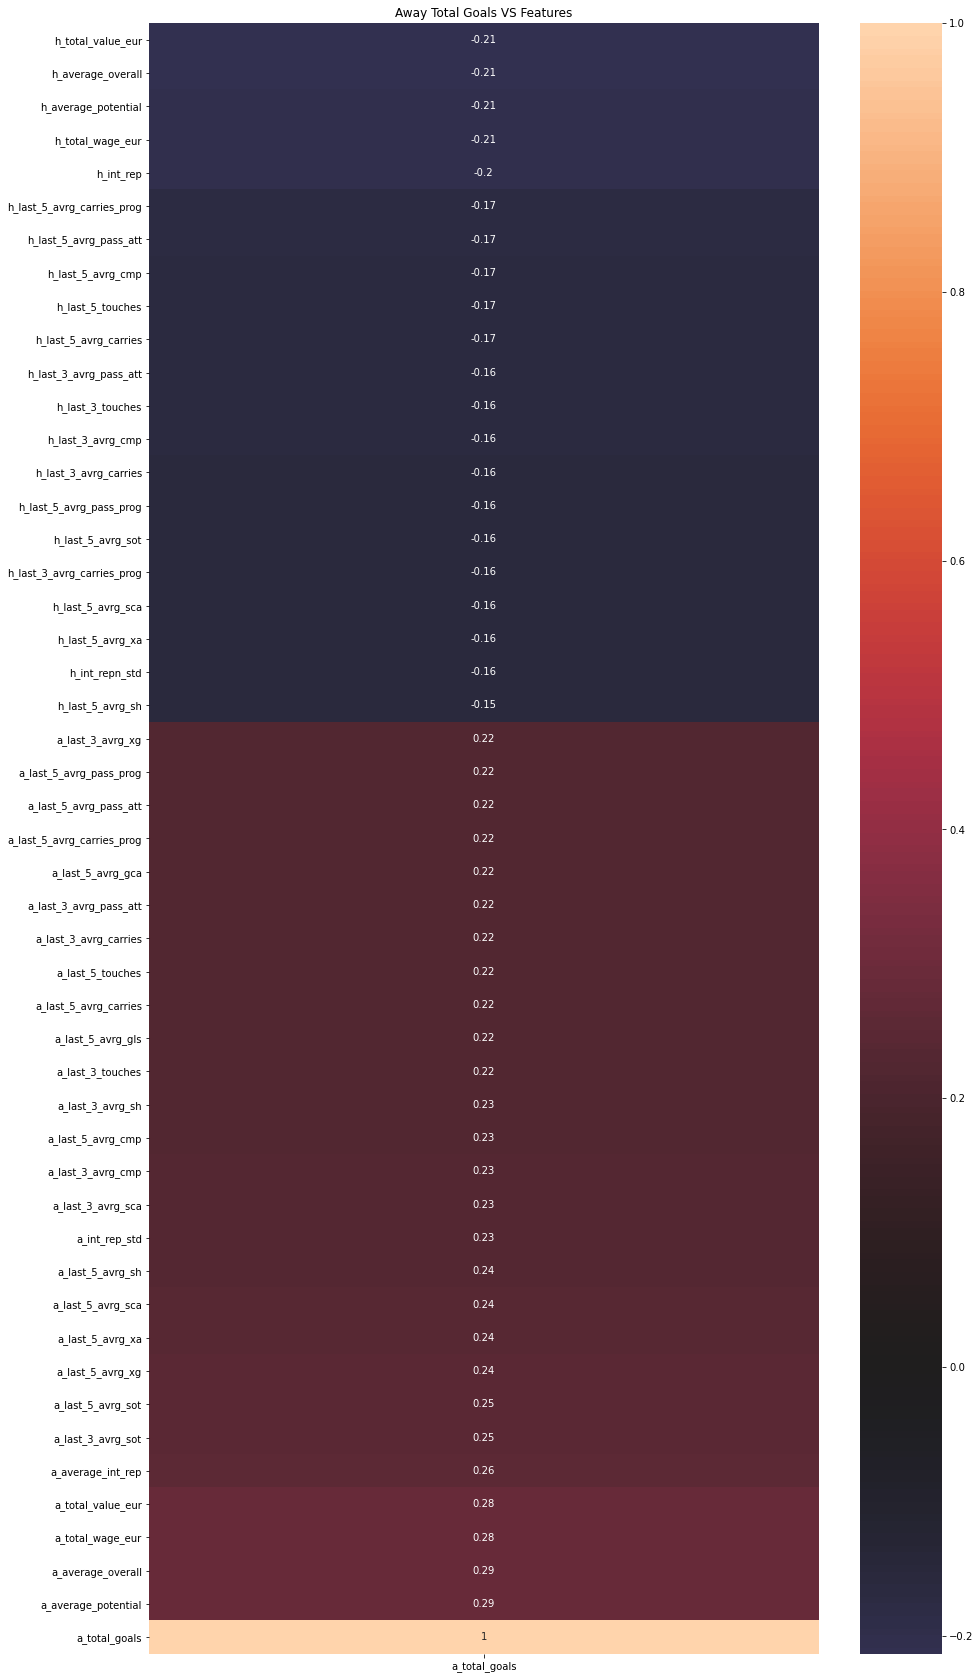

In [17]:
#Restudying the heatmap of the correlation between away total goals and remaining features
#Correlation between result and other features
plt.figure(figsize=(15,30))
sns.heatmap(train_a.corr()[['a_total_goals']].sort_values('a_total_goals'), annot=True,center =0)
plt.title('Away Total Goals VS Features')

Most of the remaining features are mixture of home and away team stats. There is also a number of past matches stats.

In [18]:
#Final Shape of data
train_a.shape

(1302, 54)

## Building the Model

### Train Test Split for Away Total Goals

Similarly to the Home Total Goals, we will be splitting the data into train and test set. After that, we will smote the train set as the dataset is very imbalanced.

In [19]:
train_a.head()

,date,match,home,stadium,h_last_5_avrg_sh,h_last_5_avrg_sot,h_last_5_touches,h_last_5_avrg_xa,h_last_5_avrg_sca,h_last_5_avrg_cmp,h_last_5_avrg_pass_att,h_last_5_avrg_pass_prog,h_last_5_avrg_carries,h_last_5_avrg_carries_prog,h_last_3_touches,h_last_3_avrg_cmp,h_last_3_avrg_pass_att,h_last_3_avrg_carries,h_last_3_avrg_carries_prog,away,a_last_5_avrg_gls,a_last_5_avrg_sh,a_last_5_avrg_sot,a_last_5_touches,a_last_5_avrg_xg,a_last_5_avrg_xa,a_last_5_avrg_sca,a_last_5_avrg_gca,a_last_5_avrg_cmp,a_last_5_avrg_pass_att,a_last_5_avrg_pass_prog,a_last_5_avrg_carries,a_last_5_avrg_carries_prog,a_last_3_avrg_sh,a_last_3_avrg_sot,a_last_3_touches,a_last_3_avrg_xg,a_last_3_avrg_sca,a_last_3_avrg_cmp,a_last_3_avrg_pass_att,a_last_3_avrg_carries,a_total_goals,h_total_value_eur,h_total_wage_eur,h_average_overall,h_average_potential,h_int_rep,h_int_repn_std,a_total_value_eur,a_total_wage_eur,a_average_overall,a_average_potential,a_average_int_rep,a_int_rep_std
10,2017-08-19,Southampton_vs_West_Ham_United,Southampton,"St. Mary's Stadium, Southampton",30.0,3.0,645.0,1.5,47.0,437.0,549.0,41.0,439.0,60.0,645.0,437.0,549.0,439.0,60.0,West Ham United,0.0,10.0,1.0,544.0,0.6,0.5,16.0,0.0,327.0,425.0,38.0,339.0,20.0,10.0,1.0,544.0,0.6,16.0,327.0,425.0,339.0,2,192000000,1330000,77.17,80.44,1.78,0.43,210400000,1686000,77.42,79.63,2.11,0.66
11,2017-08-19,Swansea_City_vs_Manchester_United,Swansea City,"Liberty Stadium, Swansea, Glamorgan",4.0,0.0,490.0,0.3,7.0,292.0,383.0,21.0,304.0,17.0,490.0,292.0,383.0,304.0,17.0,Manchester United,4.0,22.0,5.0,636.0,2.0,2.1,32.0,7.0,429.0,524.0,44.0,409.0,52.0,22.0,5.0,636.0,2.0,32.0,429.0,524.0,409.0,4,129600000,970000,75.53,78.41,1.76,0.56,457200000,2285000,81.06,84.18,2.65,0.79
12,2017-08-19,Stoke_City_vs_Arsenal,Stoke City,"Bet365 Stadium, Stoke-on-Trent",10.0,1.0,478.0,0.1,15.0,229.0,361.0,33.0,269.0,36.0,478.0,229.0,361.0,269.0,36.0,Arsenal,4.0,28.0,10.0,782.0,2.2,2.2,51.0,7.0,546.0,659.0,50.0,593.0,90.0,28.0,10.0,782.0,2.2,51.0,546.0,659.0,593.0,0,173000000,1010000,77.31,80.19,2.00,0.37,434500000,2245000,81.11,83.94,2.72,0.96
13,2017-08-19,Burnley_vs_West_Bromwich_Albion,Burnley,"Turf Moor, Burnley",10.0,5.0,447.0,0.6,16.0,248.0,344.0,23.0,235.0,23.0,447.0,248.0,344.0,235.0,23.0,West Bromwich Albion,1.0,17.0,6.0,399.0,1.1,0.9,25.0,2.0,188.0,294.0,14.0,218.0,21.0,17.0,6.0,399.0,1.1,25.0,188.0,294.0,218.0,1,103475000,810000,74.29,76.06,1.18,0.39,128550000,1060000,75.50,77.67,1.78,0.55
14,2017-08-19,Bournemouth_vs_Watford,Bournemouth,"Vitality Stadium, Bournemouth",9.0,2.0,739.0,0.3,14.0,530.0,642.0,41.0,589.0,55.0,739.0,530.0,642.0,589.0,55.0,Watford,3.0,9.0,5.0,563.0,1.9,0.3,11.0,3.0,301.0,450.0,24.0,337.0,20.0,9.0,5.0,563.0,1.9,11.0,301.0,450.0,337.0,2,115200000,970000,74.56,78.33,1.17,0.51,142700000,870000,76.65,78.94,1.65,0.49


In [20]:
train_a_2 = train_a.drop(columns = ['a_total_goals'])

In [21]:
#Target feature is a_total_goals
X = train_a[train_a_2.columns]
y = train_a['a_total_goals']

In [22]:
X.columns

Index(['date', 'match', 'home', 'stadium', 'h_last_5_avrg_sh',
       'h_last_5_avrg_sot', 'h_last_5_touches', 'h_last_5_avrg_xa',
       'h_last_5_avrg_sca', 'h_last_5_avrg_cmp', 'h_last_5_avrg_pass_att',
       'h_last_5_avrg_pass_prog', 'h_last_5_avrg_carries',
       'h_last_5_avrg_carries_prog', 'h_last_3_touches', 'h_last_3_avrg_cmp',
       'h_last_3_avrg_pass_att', 'h_last_3_avrg_carries',
       'h_last_3_avrg_carries_prog', 'away', 'a_last_5_avrg_gls',
       'a_last_5_avrg_sh', 'a_last_5_avrg_sot', 'a_last_5_touches',
       'a_last_5_avrg_xg', 'a_last_5_avrg_xa', 'a_last_5_avrg_sca',
       'a_last_5_avrg_gca', 'a_last_5_avrg_cmp', 'a_last_5_avrg_pass_att',
       'a_last_5_avrg_pass_prog', 'a_last_5_avrg_carries',
       'a_last_5_avrg_carries_prog', 'a_last_3_avrg_sh', 'a_last_3_avrg_sot',
       'a_last_3_touches', 'a_last_3_avrg_xg', 'a_last_3_avrg_sca',
       'a_last_3_avrg_cmp', 'a_last_3_avrg_pass_att', 'a_last_3_avrg_carries',
       'h_total_value_eur', 'h_total_w

In [23]:
X.shape

(1302, 53)

In [24]:
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, random_state=42,shuffle=False)

In [25]:
#Dropping irrelevant features
X_train = X_train_full.drop(columns = ['date','match','home','away','stadium'])
X_test = X_test_full.drop(columns = ['date','match','home','away','stadium'])

In [26]:
#As the ranges of the features are differnet, lets normalize
mm = MinMaxScaler()
Xmm_train = mm.fit_transform(X_train)
Xmm_test = mm.transform(X_test)

In [27]:
#Baseline score before SMOTE-ing
y_train.value_counts(normalize=True)

1    0.334016
0    0.324795
2    0.210041
3    0.086066
4    0.030738
5    0.011270
6    0.003074
Name: a_total_goals, dtype: float64

In [28]:
#Smote to balance the class
sm = SMOTE(random_state=42,k_neighbors=1)

Xsm_train, ysm_train = sm.fit_sample(Xmm_train, y_train)

In [29]:
#Baseline score after SMOTE-ing
ysm_train.value_counts(normalize=True)

0    0.142857
2    0.142857
4    0.142857
6    0.142857
1    0.142857
3    0.142857
5    0.142857
Name: a_total_goals, dtype: float64

### Logistic Regression

In this section, we will explore using Logistic Regression.

In [30]:
#Gridsearch to look for best params
lr = LogisticRegression(random_state=42)
lr_params = {
    'C': np.linspace(0.1,1,5)
}
#Gridsearch and fit the model
gs_lr = GridSearchCV(lr, param_grid = lr_params, cv=5,n_jobs=-1, verbose=1,scoring='f1_micro')
gs_lr.fit(Xsm_train, ysm_train)

#Getting the best params
gs_lr.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.7s finished


LogisticRegression(random_state=42)

In [31]:
lr = LogisticRegression(random_state=42)

In [32]:
lr.fit(Xsm_train, ysm_train)

LogisticRegression(random_state=42)

In [33]:
lr_preds = lr.predict(Xmm_test)

#### Evaluation of Logistic Regression Model

In [34]:
#LogReg Scoring
print(lr.score(Xsm_train, ysm_train))
print(lr.score(Xmm_test,y_test))

0.5341805433829974
0.26380368098159507


In [35]:
#Getting features coefficients
lr_coeff = np.exp(lr.coef_[0])
imp_lr = pd.DataFrame(lr_coeff, X_train.columns, columns=['coef']).sort_values(by='coef',ascending=False)
imp_lr.head(53)

,coef
h_last_5_avrg_sot,4.371512
h_total_value_eur,3.322532
a_last_5_avrg_pass_prog,2.093198
h_int_rep,1.929897
h_last_5_avrg_sh,1.925181
h_total_wage_eur,1.902690
a_last_5_avrg_sca,1.847141
a_last_3_avrg_xg,1.756142
h_average_overall,1.706304
h_last_5_avrg_sca,1.663337


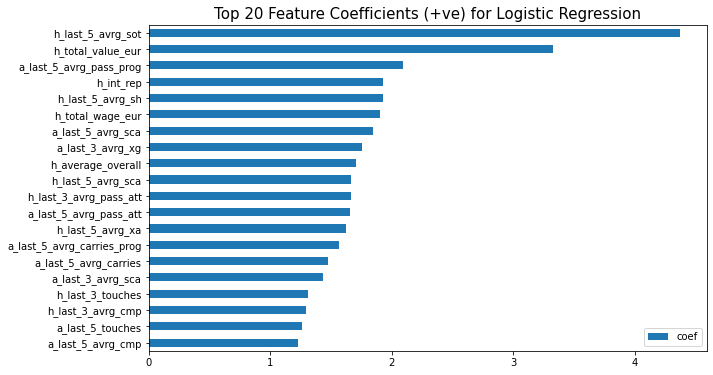

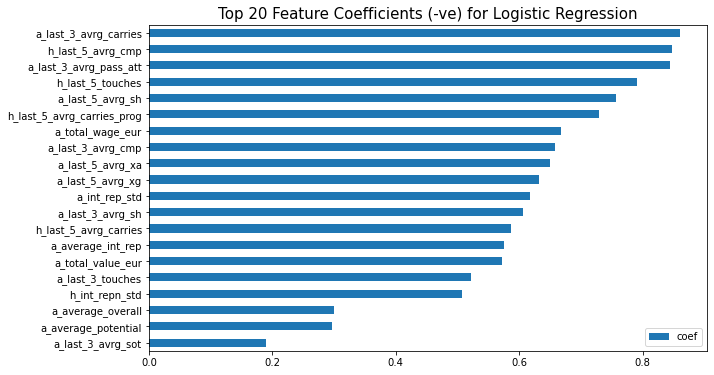

In [36]:
# Plotting top 20 +ve features in bar chart
imp_lr.head(20).plot(kind='barh', figsize=(10,6))
plt.title('Top 20 Feature Coefficients (+ve) for Logistic Regression', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

#Plotting top 20-ve features in bar chart
imp_lr.tail(20).plot(kind='barh', figsize=(10,6))
plt.title('Top 20 Feature Coefficients (-ve) for Logistic Regression', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

There is an overfitting based on the train and test score. The test score is quite bad as there is a difference of 0.7 with the baseline.

In the top positive coefficients and top negative coefficients, there is a mixture of team statistics and past matches performance. Mostly home team related features in the top 20 positive, whereas top 20 negative are mostly away team features.

In [37]:
# Initialize empty list to store all the scores and corresponding model names
model_name = []
model_scores = []
model_var = []
model_test_scores = []

# Append to the lists
model_name.append('Logistic Regression')
model_scores.append(lr.score(Xsm_train, ysm_train))
model_var.append(lr)
model_test_scores.append(lr.score(Xmm_test,y_test))

### Random Forest Classification

In this section, we will explore using Random Forest Classification.

In [38]:
rf = RandomForestClassifier(random_state=42)
#Include params to test
rf_params = {
    'n_estimators': [80, 100, 120],
    'max_depth': [3, 5],
    'min_samples_leaf': [2, 4],
    'min_samples_split' : [2, 4]
}
#Grid-Searching
gs_rf = GridSearchCV(rf, param_grid = rf_params, cv=5,n_jobs=-1,verbose=1,scoring='f1_micro')
#Fitting the model and getting the best estimator
gs_rf.fit(Xsm_train, ysm_train)
gs_rf.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.4s finished


RandomForestClassifier(max_depth=5, min_samples_leaf=2, random_state=42)

In [39]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=80,
                       random_state=42)

In [40]:
rf.fit(Xsm_train, ysm_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=80,
                       random_state=42)

#### Evaluation of Random Forest Model

In [41]:
print(rf.score(Xsm_train, ysm_train))
print(rf.score(Xmm_test,y_test))

0.7134092900964066
0.3006134969325153


In [42]:
#Random Forest Features ranked by importanc
rf_impt_feature = rf.feature_importances_
rf_impt_df = pd.DataFrame(index = X_test.columns, data = rf_impt_feature, columns = ['Importance']).sort_values('Importance',ascending=False)
rf_impt_df.head()

,Importance
a_last_5_avrg_gca,0.053911
a_last_5_avrg_gls,0.047157
a_average_overall,0.046846
a_last_3_avrg_carries,0.045715
a_total_value_eur,0.037264


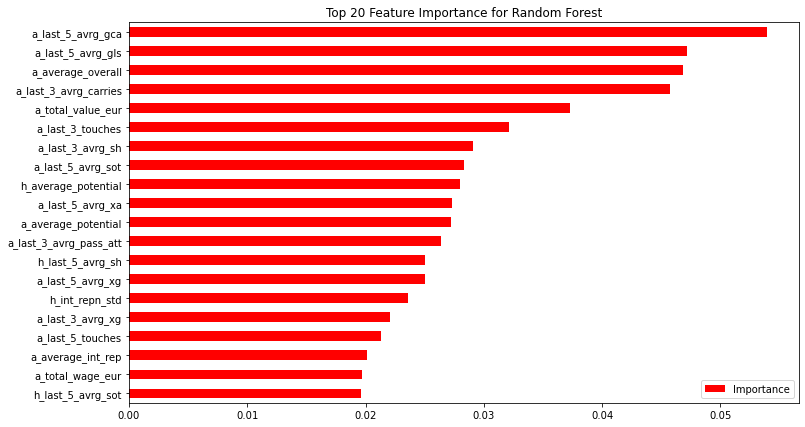

In [43]:
rf_impt_df.head(20).plot(kind='barh',figsize=(12,7),color='red',label=rf_impt_df.columns[:20])
plt.title('Top 20 Feature Importance for Random Forest')
plt.gca().invert_yaxis()
plt.legend(loc=4);

The training score and test score are very wide apart. There is alot of overfitting in the data. The test score is slightly better as compared to Logistic Regression's score.

Among the top 20 important features, most of them are past matches stats. There is also the away team stats such as overall, value and potential. 

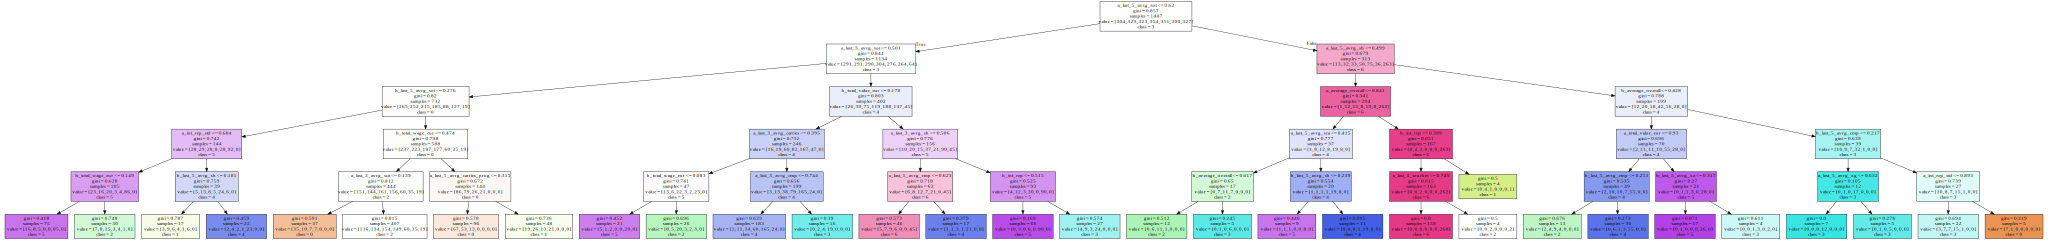

In [44]:
# DOT data
dotfile = open("images/tree_away_goals.dot", 'w')
dot_data = export_graphviz(rf.estimators_[10], out_file=None, 
                               feature_names= X_train.columns,  
                               class_names=['0','1','2','3','4','5','6'],
                                filled=True)

#Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

Based on the graph above, similar to the top important features, the model looked at a mixture of past match performance and team stats. However, the main factors are the past matches sot,shots on target and sh, shots attempted. These are quite related to goal scoring build up. Average Overall are also taken into consideration in this tree.

In [45]:
# Append to the lists
model_name.append('Random Forest')
model_scores.append(rf.score(Xsm_train, ysm_train))
model_var.append(rf)
model_test_scores.append(rf.score(Xmm_test,y_test))

### ExtraTrees Classifier

In this section, we will explore the Extra Trees Classifier.

In [46]:
et = ExtraTreesClassifier(random_state=42)
# Including hyperparameters
et_params = {
    'n_estimators': [80, 100, 120],
    'max_depth': [3, 5],
    'min_samples_leaf': [2, 4],
    'min_samples_split' : [2, 4],
}
#Grid-Searching
gs_et = GridSearchCV(et, param_grid = et_params, cv=5,n_jobs=-1,verbose=1,scoring='f1_micro')
gs_et.fit(Xsm_train, ysm_train)
#Getting the best estimator
gs_et.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.8s finished


ExtraTreesClassifier(max_depth=5, min_samples_leaf=2, n_estimators=120,
                     random_state=42)

In [47]:
#Using the best parameters and fit the model
et = ExtraTreesClassifier(max_depth=5, min_samples_leaf=2, random_state=42)
et.fit(Xsm_train, ysm_train)

ExtraTreesClassifier(max_depth=5, min_samples_leaf=2, random_state=42)

#### Evaluation of ExtraTrees Classifier

In [48]:
print(et.score(Xsm_train,ysm_train))
print(et.score(Xmm_test,y_test))

0.6884312007011394
0.30368098159509205


In [49]:
et_impt_feature = et.feature_importances_
et_impt_df = pd.DataFrame(index = X_test.columns, data = et_impt_feature, columns = ['Importance']).sort_values('Importance',ascending=False)
et_impt_df.head()


,Importance
a_average_int_rep,0.051295
a_total_wage_eur,0.046254
a_average_overall,0.040209
a_total_value_eur,0.038450
a_last_5_avrg_gls,0.034240


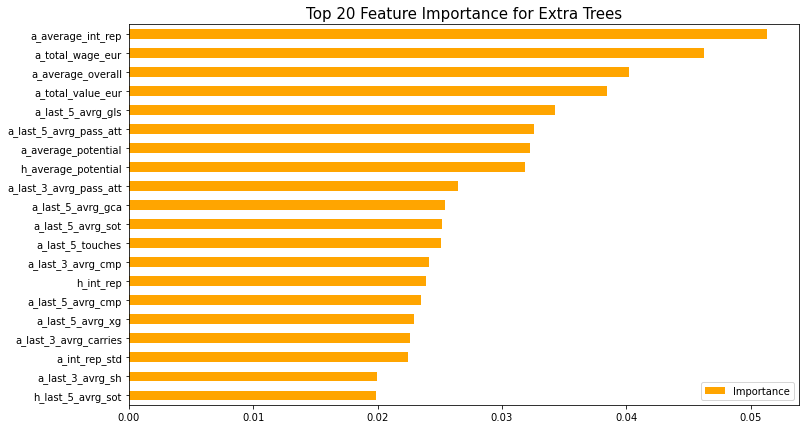

In [50]:
# Top 20 features plot
et_impt_df.head(20).plot(kind='barh', label=et_impt_df.columns, figsize=(12,7), color='orange')
plt.title('Top 20 Feature Importance for Extra Trees', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

The top 20 important features for Extra Tree model are mostly team statistics and are mostly away team's.

There is an overfit based on the train and test score. The test score is still lower than the baseline score.

In [51]:
# Append to the lists
model_name.append('Extra Trees')
model_scores.append(et.score(Xsm_train, ysm_train))
model_var.append(et)
model_test_scores.append(et.score(Xmm_test,y_test))

### Ada Boost Classifier 

In this section, we will explore the usage of Ada Boost Classifier.

In [52]:
ada =  AdaBoostClassifier(random_state=42)

# Hyperparameters
ada_params = {
    'n_estimators': [20, 30, 40, 50],
    'learning_rate': [0.8, 0.9, 1]
}

gs_ada = GridSearchCV(ada, param_grid = ada_params, cv=5, n_jobs=-1,verbose=1,scoring='f1_micro')
gs_ada.fit(Xsm_train, ysm_train)
gs_ada.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.0s finished


AdaBoostClassifier(learning_rate=0.8, random_state=42)

In [53]:
ada = AdaBoostClassifier(learning_rate=0.9, n_estimators=20, random_state=42)
ada.fit(Xsm_train, ysm_train)

AdaBoostClassifier(learning_rate=0.9, n_estimators=20, random_state=42)

#### Evaluation of AdaBoost Classifier

In [54]:
print(ada.score(Xsm_train, ysm_train))
print(ada.score(Xmm_test,y_test))

0.31507449605609117
0.3067484662576687


In [55]:
ada_impt_feature = ada.feature_importances_
ada_impt_df = pd.DataFrame(index = X_test.columns, data = ada_impt_feature, columns = ['Importance']).sort_values('Importance',ascending=False)
ada_impt_df.head()

,Importance
a_last_3_avrg_sh,0.25
a_last_5_avrg_gca,0.20
a_average_overall,0.15
h_last_5_avrg_sca,0.10
a_total_value_eur,0.10


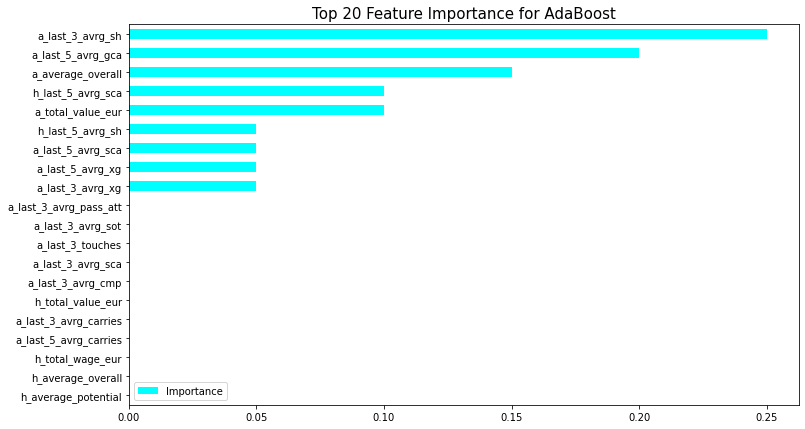

In [56]:
ada_impt_df.head(20).plot(kind='barh', label=ada_impt_df.columns[:20], figsize=(12,7), color='cyan')
plt.title('Top 20 Feature Importance for AdaBoost', fontsize=15)
plt.gca().invert_yaxis()

There are a mixture of past matches stats and team stats for the top important features. Average Overall still appears as one of the important feature, whereas the top two are past matches stats, shots and goal-creating actions.

There is a little overfit in this model. The test score is still lower than the baseline. 

In [57]:
# Append to the lists
model_name.append('AdaBoost')
model_scores.append(ada.score(Xsm_train, ysm_train))
model_var.append(ada)
model_test_scores.append(ada.score(Xmm_test,y_test))

### Gradient Boost Classifier

In this section, we will explore the usage of gradient boost classifier.

In [58]:
gboost = GradientBoostingClassifier(random_state=42)
#Setting the params
gboost_params = {
    'n_estimators': [80, 100, 120, 150],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]}
    
#Grid searching    
gs_gboost = GridSearchCV(gboost, param_grid = gboost_params, cv=5,n_jobs=-1,verbose=1,scoring='f1_micro')
#Fit the model
gs_gboost.fit(Xsm_train, ysm_train)
#Getting the best params
gs_gboost.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.9min finished


GradientBoostingClassifier(min_samples_leaf=2, n_estimators=150,
                           random_state=42)

In [59]:
gboost = GradientBoostingClassifier(min_samples_split=4, n_estimators=150,
                           random_state=42)
gboost.fit(Xsm_train, ysm_train)

GradientBoostingClassifier(min_samples_split=4, n_estimators=150,
                           random_state=42)

#### Evaluation of Gradient Boost Classifier

In [60]:
print(gboost.score(Xsm_train,ysm_train))
print(gboost.score(Xmm_test,y_test))

0.9943032427695004
0.3159509202453988


In [61]:
imp_gboost = pd.DataFrame(gboost.feature_importances_,index=X_test.columns,columns=['importance']).sort_values(by='importance', ascending=False)
imp_gboost.head()

,importance
a_last_5_avrg_gca,0.098405
a_last_3_avrg_xg,0.077929
a_last_5_avrg_gls,0.051520
h_last_5_avrg_sot,0.043451
a_int_rep_std,0.035161


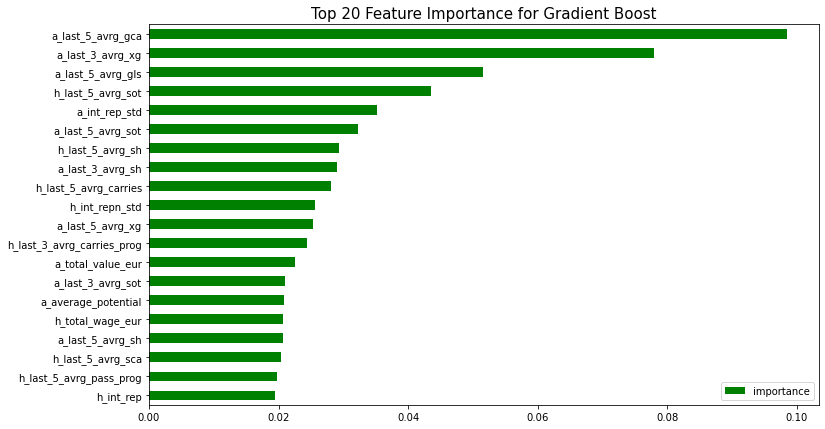

In [62]:
# Plot in bar chart
imp_gboost.head(20).plot(kind='barh', label=imp_gboost.columns[:20], figsize=(12,7), color='green')
plt.title('Top 20 Feature Importance for Gradient Boost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

Most of the top features for Gradient Boost are past matches stats. They looks at goal creating features as well, such as goal creating actions, expected goals, goals and shot of targets.

There is a large overfit based on the score. However, the test score is getting near to the baseline score.

In [63]:
# Append to the lists
model_name.append('GradientBoosting')
model_scores.append(gboost.score(Xsm_train, ysm_train))
model_var.append(gboost)
model_test_scores.append(gboost.score(Xmm_test, y_test))

### Support Vector Classifier

In this section, we will be using support vector classifier.

In [64]:
svc = SVC(random_state=42)

# Setting Params
svc_params = {
    'C': [1, 0.1],
    'kernel': ['poly','rbf'],
    'degree': [1,2]
}

gs_svc = GridSearchCV(svc, param_grid = svc_params, cv=5,n_jobs=-1, verbose=1,scoring='f1_micro')

gs_svc.fit(Xsm_train, ysm_train)
#Getting the best params
gs_svc.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.9s finished


SVC(C=1, degree=1, random_state=42)

In [65]:
svc = SVC(C=1, degree=1, random_state=42,probability=True)
svc.fit(Xsm_train, ysm_train)

SVC(C=1, degree=1, probability=True, random_state=42)

In [66]:
print(svc.score(Xmm_train,y_train))
print(svc.score(Xmm_test,y_test))

0.4733606557377049
0.3220858895705521


There is an overfit using the support vector classifier model. The test score is nearest to the baseline, compared to the rest of the models.

In [67]:
model_name.append('Support Vector Classifier')
model_scores.append(svc.score(Xsm_train, ysm_train))
model_var.append(svc)
model_test_scores.append(svc.score(Xmm_test,y_test))

### Model Evaluation & Selection

In [68]:
model_var

[LogisticRegression(random_state=42),
 RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=80,
                        random_state=42),
 ExtraTreesClassifier(max_depth=5, min_samples_leaf=2, random_state=42),
 AdaBoostClassifier(learning_rate=0.9, n_estimators=20, random_state=42),
 GradientBoostingClassifier(min_samples_split=4, n_estimators=150,
                            random_state=42),
 SVC(C=1, degree=1, probability=True, random_state=42)]

In [70]:
# View the evaluation metrics for all models in a dataframe
# Sorted by highest F1-Score
precision_list = []
recall_list = []
fscore_list = []

for model in model_var:
    y_pred = model.predict(Xmm_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,average = 'micro')
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

In [71]:
pd.DataFrame({'Model Type': model_name,
              'F1-Score': fscore_list,
             'Recall': recall_list,
              'Precision': precision_list,
              'Train Accuracy': model_scores,
             'Test Accuracy': model_test_scores}).sort_values(by='F1-Score',ascending=False)

,Model Type,F1-Score,Recall,Precision,Train Accuracy,Test Accuracy
5,Support Vector Classifier,0.322086,0.322086,0.322086,0.706398,0.322086
4,GradientBoosting,0.315951,0.315951,0.315951,0.994303,0.315951
3,AdaBoost,0.306748,0.306748,0.306748,0.315074,0.306748
2,Extra Trees,0.303681,0.303681,0.303681,0.688431,0.303681
1,Random Forest,0.300613,0.300613,0.300613,0.713409,0.300613
0,Logistic Regression,0.263804,0.263804,0.263804,0.534181,0.263804


In [72]:
#Plotting of confusion Matrix
def subplot_confusion_matrix(model_list, model_name, Xmm_test, y_test):
    nrows = int(np.ceil(len(model_list)/3))   # Ensure have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(14, nrows*4))   
    plt.subplots_adjust(hspace = 0.4)
    ax = ax.ravel()   # Ravel turns a matrix into a vector, which is easier to iterate
    for i, model in enumerate(model_list):   # Gives us an index value to get into all our lists
        plot_confusion_matrix(model, Xmm_test, y_test, cmap='Blues', values_format='d', ax=ax[i])
        ax[i].set_title(model_name[i])
    
        # display scale and label only on the left edge
        if i%3 != 0:
            ax[i].set_ylabel('')
            ax[i].set_yticklabels('')
    # This code below is to switch off the axes if there is an odd number of subplots
    for axes in ax.flat[len(model_list):]:
        axes.axis('off')
    fig.tight_layout()
    pass

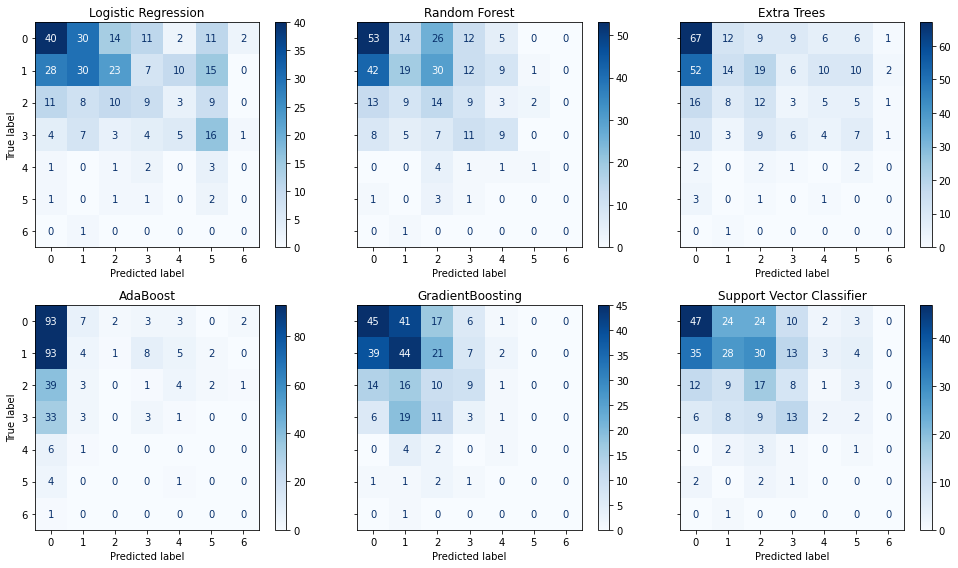

In [73]:
subplot_confusion_matrix(model_var, model_name, Xmm_test, y_test)

Similarly to home total goals model, we will be using F1 Score Micro-Average as the metric in this machine learning model. It is because there are seven different classes and the data is imbalance. Based on the scores, we will select Support Vector Classifier as our production model. 

[Support Vector Machine](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47) aims to find a hyperplane in an N-dimensional space(N--the number of features) that distinctly classifies the data points.

Hyperplanes are decision boundaries that help classify the data points. Data points falling on either side of the hyperplane can be attributed to different classes. The objective of the algorithm is to find the the plane with the maximum distance between data points of the different classes.

Advantages:

- SVM works relatively well when there is a clear margin of separation between classes.
- SVM is more effective in high dimensional spaces.

Disadvantages:

- SVM algorithm is not suitable for large data sets.
- SVM does not perform very well when the data set has more noise i.e. target classes are overlapping.
- In cases where the number of features for each data point exceeds the number of training data samples, the SVM will underperform.


In [74]:
#Saving scaler as pickle
filename = 'away_goals_scaler.pkl'
pickle.dump(mm, open(filename, 'wb'))

In [75]:
#Saving model as pickle
filename = 'away_goals_production_model.pkl'
pickle.dump(svc, open(filename, 'wb'))